In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/d2l-ai/d2l-zh (to revision release) to /tmp/pip-req-build-57z31gry
  Running command git clone -q https://github.com/d2l-ai/d2l-zh /tmp/pip-req-build-57z31gry
  Running command git checkout -b release --track origin/release
  Switched to a new branch 'release'
  Branch 'release' set up to track remote branch 'release' from 'origin'.
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 15.7 MB 43.6 MB/s 
     |████████████████████████████████| 11.2 MB 64.4 MB/s 
     |████████████████████████████████| 61 kB 9.8 MB/s 
     |████████████████████████████████| 9.9 MB 75.3 MB/s 
     |████████████████████████████████| 121 kB 99.5 MB/s 
     |████████████████████████████████| 965 kB 66.3 MB/s 
     |████████████████████████████████| 1.6 MB 65.1 MB/s 
     |████████████████████████████████| 82 kB 1.1 MB/s 
  Created whee

In [ ]:
pip install matplotlib-inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import re
import torch
from torch import nn
from d2l import torch as d2l

import json
import multiprocessing

#@save
d2l.DATA_HUB['SNLI'] = (
    'https://nlp.stanford.edu/projects/snli/snli_1.0.zip',
    '9fcde07509c7e87ec61c640c1b2753d9041758e4')

data_dir = d2l.download_extract('SNLI')

正在从https://nlp.stanford.edu/projects/snli/snli_1.0.zip下载../data/snli_1.0.zip...


In [ ]:
#@save
def read_snli(data_dir, is_train):
    """将SNLI数据集解析为前提、假设和标签"""
    def extract_text(s):
        # 删除我们不会使用的信息
        s = re.sub('\\(', '', s)
        s = re.sub('\\)', '', s)
        # 用一个空格替换两个或多个连续的空格
        s = re.sub('\\s{2,}', ' ', s)
        return s.strip()
    label_set = {'entailment': 0, 'contradiction': 1, 'neutral': 2}
    file_name = os.path.join(data_dir, 'snli_1.0_train.txt'
                             if is_train else 'snli_1.0_test.txt')
    with open(file_name, 'r') as f:
        rows = [row.split('\t') for row in f.readlines()[1:]]
    premises = [extract_text(row[1]) for row in rows if row[0] in label_set]
    hypotheses = [extract_text(row[2]) for row in rows if row[0] \
                in label_set]
    labels = [label_set[row[0]] for row in rows if row[0] in label_set]
    return premises, hypotheses, labels

In [ ]:
train_data = read_snli(data_dir, is_train=True)
# train_data -> list of 3 sublists
# 打印前三个测试
# train_data[0][:3]前提的前三个样本
for x0, x1, y in zip(train_data[0][:3], train_data[1][:3], train_data[2][:3]):
    print('前提：', x0)
    print('假设：', x1)
    print('标签：', y)

前提： A person on a horse jumps over a broken down airplane .
假设： A person is training his horse for a competition .
标签： 2
前提： A person on a horse jumps over a broken down airplane .
假设： A person is at a diner , ordering an omelette .
标签： 1
前提： A person on a horse jumps over a broken down airplane .
假设： A person is outdoors , on a horse .
标签： 0


In [ ]:
# data[2] -> label
# 打印train跟test dataset中， 0，1,2三种label的个数分别有多少
test_data = read_snli(data_dir, is_train=False)
for data in [train_data, test_data]:
    print([[row for row in data[2]].count(i) for i in range(3)])

[183416, 183187, 182764]
[3368, 3237, 3219]


In [ ]:
# #@save
# ## 下载的模型里一定会有个vocab，这样才能把我的数据映射成模型能识别的
# ## 所以需要允许传入，自己构建只能是个从零开始的训练
# class SNLIDataset(torch.utils.data.Dataset):
#     """用于加载SNLI数据集的自定义数据集"""
#     def __init__(self, dataset, num_steps, vocab=None):
#         self.num_steps = num_steps
#         all_premise_tokens = d2l.tokenize(dataset[0])
#         all_hypothesis_tokens = d2l.tokenize(dataset[1])
#         if vocab is None:
#             self.vocab = d2l.Vocab(all_premise_tokens + \
#                 all_hypothesis_tokens, min_freq=5, reserved_tokens=['<pad>'])
#         else:
#             self.vocab = vocab
#         self.premises = self._pad(all_premise_tokens)
#         self.hypotheses = self._pad(all_hypothesis_tokens)
#         self.labels = torch.tensor(dataset[2])
#         print('read ' + str(len(self.premises)) + ' examples')

#     def _pad(self, lines):
#         return torch.tensor([d2l.truncate_pad(
#             self.vocab[line], self.num_steps, self.vocab['<pad>'])
#                          for line in lines])

#     def __getitem__(self, idx):
#         return (self.premises[idx], self.hypotheses[idx]), self.labels[idx]

#     def __len__(self):
#         return len(self.premises)

In [ ]:
d2l.DATA_HUB['bert.base'] = (d2l.DATA_URL + 'bert.base.torch.zip',
                             '225d66f04cae318b841a13d32af3acc165f253ac')
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip',
                              'c72329e68a732bef0452e4b96a1c341c8910f81f')

In [ ]:
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
                          num_heads, num_layers, dropout, max_len, devices):
    data_dir = d2l.download_extract(pretrained_model)
    # 定义空词表以加载预定义词表
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir,
        'vocab.json')))
    vocab.token_to_idx = {token: idx for idx, token in enumerate(
        vocab.idx_to_token)}
    bert = d2l.BERTModel(len(vocab), num_hiddens, norm_shape=[256],
                         ffn_num_input=256, ffn_num_hiddens=ffn_num_hiddens,
                         num_heads=4, num_layers=2, dropout=0.2,
                         max_len=max_len, key_size=256, query_size=256,
                         value_size=256, hid_in_features=256,
                         mlm_in_features=256, nsp_in_features=256)
    # 加载预训练BERT参数
    bert.load_state_dict(torch.load(os.path.join(data_dir,
                                                 'pretrained.params')))
    return bert, vocab

In [ ]:
devices = d2l.try_all_gpus()
bert, vocab = load_pretrained_model(
    'bert.small', num_hiddens=256, ffn_num_hiddens=512, num_heads=4,
    num_layers=2, dropout=0.1, max_len=512, devices=devices)

正在从http://d2l-data.s3-accelerate.amazonaws.com/bert.small.torch.zip下载../data/bert.small.torch.zip...


In [ ]:
# tensor(25)
train_set.all_segments[0]


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# len(train_set.all_token_ids)
print(train_set.valid_lens.shape)
train_set.all_token_ids[0]

torch.Size([549367])


tensor([    3,    12,   844,    17,    12,  1710, 12168,    66,    12,  2355,
          318, 10014,     7,     4,    12,   844,    15,   568,    28,  1710,
           16,    12,   668,     7,     4,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1])

In [ ]:
test_set.labels.dtype

torch.int64

In [ ]:
class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
      # all_premise_hypothesis_tokens 把p跟h都转换成Tokens
        all_premise_hypothesis_tokens = [[
            p_tokens, h_tokens] for p_tokens, h_tokens in zip(
            *[d2l.tokenize([s.lower() for s in sentences])
              for sentences in dataset[:2]])] # for sentences in dataset[:2]])] sentences[0]=前提 sentences[1]=假设
        print("type: ", type(all_premise_hypothesis_tokens))
        self.labels = torch.tensor(dataset[2])
        print("len of labels", len( self.labels))
        print("label type ", self.labels.dtype)
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,
         self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print("tokens")
        print(len(all_premise_hypothesis_tokens))
        print("token[0]")
        print(len(all_premise_hypothesis_tokens[0][0]))
        print(all_premise_hypothesis_tokens[0][0])
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_premise_hypothesis_tokens):
        pool = multiprocessing.Pool(4)  # 使用4个进程
        out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        all_token_ids = [
            token_ids for token_ids, segments, valid_len in out]
        print("out 1 ", out[0])
        print("out 2 ", out[2])
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        print("_preprocess ", type(all_token_ids) )
        print("_preprocess ", type(all_token_ids[0]) )
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(all_segments, dtype=torch.long),
                torch.tensor(valid_lens))

    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                             * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # 为BERT输入中的'<CLS>'、'<SEP>'和'<SEP>'词元保留位置
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)
train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), max_len, vocab)

type:  <class 'list'>
len of labels 549367
label type  torch.int64
out 1  ([3, 12, 844, 17, 12, 1710, 12168, 66, 12, 2355, 318, 10014, 7, 4, 12, 844, 15, 568, 28, 1710, 16, 12, 668, 7, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 25)
out 2  ([3, 12, 844, 17, 12, 1710, 12168, 66, 12, 2355, 318, 10014, 7, 4, 12, 844, 15, 14142, 6, 17, 12, 1710, 7

In [ ]:
# 实例化SNLIBERTDataset类来生成训练和测试样本
# 如果出现显存不足错误，请减少“batch_size”。在原始的BERT模型中，max_len=512
batch_size, max_len, num_workers = 512, 128, d2l.get_dataloader_workers()
data_dir = d2l.download_extract('SNLI')
train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), max_len, vocab)
test_set = SNLIBERTDataset(d2l.read_snli(data_dir, False), max_len, vocab)
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True,
                                   num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                  num_workers=num_workers)

type:  <class 'list'>
label type  torch.int64
out 1  ([3, 12, 844, 17, 12, 1710, 12168, 66, 12, 2355, 318, 10014, 7, 4, 12, 844, 15, 568, 28, 1710, 16, 12, 668, 7, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 25)
out 2  ([3, 12, 844, 17, 12, 1710, 12168, 66, 12, 2355, 318, 10014, 7, 4, 12, 844, 15, 14142, 6, 17, 12, 1710, 7, 4, 1, 1, 1, 1, 1, 1

In [ ]:
type(train_set)
len(train_iter)

1073

##微调BERT

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder
        self.hidden = bert.hidden
        self.output = nn.Linear(256, 3)

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[:, 0, :])) #batch size保留，sequence拿第一个token的embedding特征。 bert.hidden带activation

In [ ]:
net = BERTClassifier(bert) # <- load_pretrained_model

loss 0.520, train acc 0.791, test acc 0.783
2514.2 examples/sec on [device(type='cuda', index=0)]


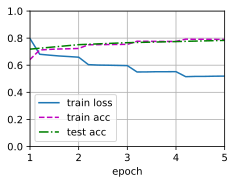

In [ ]:
lr, num_epochs = 1e-4, 5  #实际训练可以试试2,30个epochs
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
    devices)

# 可以把最后一层的学习率弄成e-1,-2。 因为最上面这层是随机初始化的。 可以让他训练快一点
# 也可以把transformer下面一些层给固定住postional embedding, 底层的transformer blcok等等不让它训练。这样backward会快一些

In [ ]:
test_data 